# Goal

* Simulating fullCyc gradient(s) using SIPSim and comparing simulated to empirical data
* Increasing pre-fractionated community richness beyond measured richness

## Init

In [1]:
import os
import glob
import cPickle as pickle
import copy
import re
import nestly

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Nestly

* assuming fragments already simulated

In [97]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/'
buildDir = os.path.join(workDir, 'DBL_xRich')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile= os.path.join(workDir, 'ampFrags.pkl')
targetFile = '/home/nick/notebook/SIPSim/dev/fullCyc/CD-HIT/target_taxa.txt'

physeqDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq_bulkCore = 'bulk-core'
physeq_SIP_core = 'SIP-core_unk'

bulk_days = 1

seq_per_fraction = ['lognormal', 9.432, 0.5, 10000, 80000] # dist, mean, scale, min, max
prefrac_comm_abundance = '5e9'
nprocs = 14

In [98]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('richness_needed', [4000, 6000, 8000])

## set params
nest.add('bulk_day', [bulk_days], create_dir=False)
nest.add('percIncorp', [0], create_dir=False)
nest.add('percTaxa', [0], create_dir=False)
nest.add('np', [nprocs], create_dir=False)
nest.add('abs', [prefrac_comm_abundance], create_dir=False)
nest.add('subsample_dist', [seq_per_fraction[0]], create_dir=False)
nest.add('subsample_mean', [seq_per_fraction[1]], create_dir=False)
nest.add('subsample_scale', [seq_per_fraction[2]], create_dir=False)
nest.add('subsample_min', [seq_per_fraction[3]], create_dir=False)
nest.add('subsample_max', [seq_per_fraction[4]], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('targetFile', [targetFile], create_dir=False)
nest.add('physeqDir', [physeqDir], create_dir=False)
nest.add('physeq_bulkCore', [physeq_bulkCore], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [99]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

#-- making DNA pool similar to gradient of interest
echo '# Creating comm file from phyloseq'
phyloseq2comm.r {physeqDir}{physeq_bulkCore} -s 12C-Con -d {bulk_day} > {physeq_bulkCore}_comm.txt
printf 'Number of lines: '; wc -l {physeq_bulkCore}_comm.txt

echo '## Adding target taxa to comm file'
comm_add_target.r {physeq_bulkCore}_comm.txt {targetFile} > {physeq_bulkCore}_comm_target.txt
printf 'Number of lines: '; wc -l {physeq_bulkCore}_comm_target.txt

echo '# Adding extra richness to community file'
printf "1\t{richness_needed}\n" > richness_needed.txt
comm_add_richness.r {physeq_bulkCore}_comm_target.txt richness_needed.txt > {physeq_bulkCore}_comm_all.txt

# renaming comm file for downstream pipeline
cat {physeq_bulkCore}_comm_all.txt > {physeq_bulkCore}_comm_target.txt

echo '## parsing out genome fragments to make simulated DNA pool resembling the gradient of interest'
## all OTUs without an associated reference genome will be assigned a random reference (of the reference genome pool)
### this is done through --NA-random
SIPSim fragment_KDE_parse {fragFile} {physeq_bulkCore}_comm_target.txt \
    --rename taxon_name --NA-random > fragsParsed.pkl


echo '#-- SIPSim pipeline --#'
echo '# converting fragments to KDE'
SIPSim fragment_KDE \
    fragsParsed.pkl \
    > fragsParsed_KDE.pkl
    
echo '# adding diffusion'    
SIPSim diffusion \
    fragsParsed_KDE.pkl \
    --np {np} \
    > fragsParsed_KDE_dif.pkl  
    
echo '# adding DBL contamination'
SIPSim DBL \
    fragsParsed_KDE_dif.pkl \
    --np {np} \
    > fragsParsed_KDE_dif_DBL.pkl  
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    fragsParsed_KDE_dif_DBL.pkl \
    {percTaxa}_{percIncorp}.config \
    --comm {physeq_bulkCore}_comm_target.txt \
    --np {np} \
    > fragsParsed_KDE_dif_DBL_inc.pkl
 
echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    {physeq_bulkCore}_comm_target.txt \
    > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    fragsParsed_KDE_dif_DBL_inc.pkl \
    {physeq_bulkCore}_comm_target.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
    
echo '# adding count error'
SIPSim OTU_add_error \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_negBin.txt 
    
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub_negBin.txt \
    > OTU_abs{abs}_PCR_sub_negBin_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub_negBin.txt \
    > OTU_abs{abs}_PCR_sub_negBin_meta.txt
    

#-- alternative with no PCR simulation    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_sub.txt    
    
echo '# adding count error'
SIPSim OTU_add_error \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_negBin.txt 
        
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_sub_negBin.txt \
    > OTU_abs{abs}_sub_negBin_meta.txt    

Overwriting /home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/DBL_xRich/SIPSimRun.sh


In [ ]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d DBL_xRich --log-file log.txt -j 1

2015-12-19 09:33:42,063 * INFO * Template: ./SIPSimRun.sh
2015-12-19 09:33:42,066 * INFO * [217746] Started ./SIPSimRun.sh in DBL_xRich/4000


### alterative pipeline

In [224]:
OTU_table_dir = '/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/DBL_xRich/4000/'

!cd $OTU_table_dir; \
    SIPSim OTU_PCR \
        -k 50 \
        OTU_abs5e9.txt \
        > OTU_abs5e9_PCR-k50.txt    
    

!cd $OTU_table_dir; \
    SIPSim OTU_subsample \
        --dist lognormal \
        --dist_params mean:9.432,sigma:0.5 \
        --min_size 10000 \
        --max_size 60000 \
        OTU_abs5e9_PCR-k50.txt \
        > OTU_abs5e9_PCR-k50_sub.txt

        
#!cd $OTU_table_dir; \
#    SIPSim OTU_add_error \
#        OTU_abs5e9_sub.txt \
#        > OTU_abs5e9_sub_negBin.txt

# Plotting number of taxa in each fraction

* Both simulated and emperical datasets

In [235]:
%%R
# simulated file info
OTU.table.dir = '/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/DBL_xRich/6000/'
#OTU.table.file = 'OTU_abs5e9_PCR_sub_negBin.txt'
#OTU.table.file = 'OTU_abs5e9_sub_negBin.txt'
OTU.table.file = 'OTU_abs5e9_sub.txt'
#OTU.table.file = 'OTU_abs5e9_PCR-k1_sub.txt'
#OTU.table.file = 'OTU_abs5e9_PCR-k50_sub.txt'

In [236]:
%%R -i physeqDir -i physeq_SIP_core -i bulk_days

# bulk core samples
F = file.path(physeqDir, physeq_SIP_core)
physeq.SIP.core = readRDS(F) 
physeq.SIP.core.m = physeq.SIP.core %>% sample_data

physeq.SIP.core = prune_samples(physeq.SIP.core.m$Substrate == '12C-Con' & 
                                physeq.SIP.core.m$Day %in% bulk_days, 
                                physeq.SIP.core) %>%
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.SIP.core.m = physeq.SIP.core %>% sample_data        

physeq.SIP.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7025 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 7025 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7025 tips and 7024 internal nodes ]


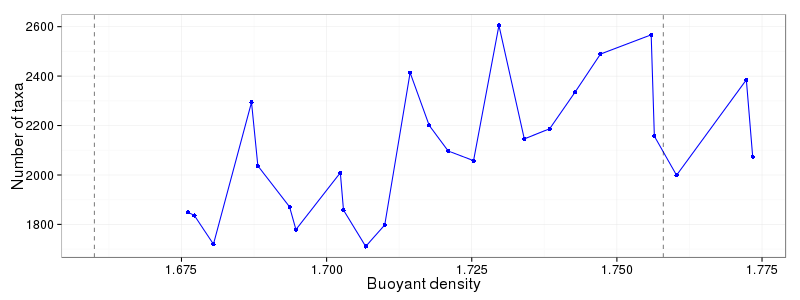

In [237]:
%%R -w 800 -h 300 

## dataframe
df.OTU = physeq.SIP.core %>% otu_table %>%
    as.matrix %>% as.data.frame
df.OTU$OTU = rownames(df.OTU)
df.OTU = df.OTU %>%    
    gather(sample, abundance, 1:(ncol(df.OTU)-1)) %>%
    group_by(sample) %>%
    summarize(n_taxa = sum(abundance > 0)) %>%
    ungroup()

df.OTU.real = inner_join(df.OTU, physeq.SIP.core.m, c('sample' = 'X.Sample')) 

## plotting
p = ggplot(df.OTU.real, aes(Buoyant_density, n_taxa)) +
    geom_point(color='blue') +
    geom_line(color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

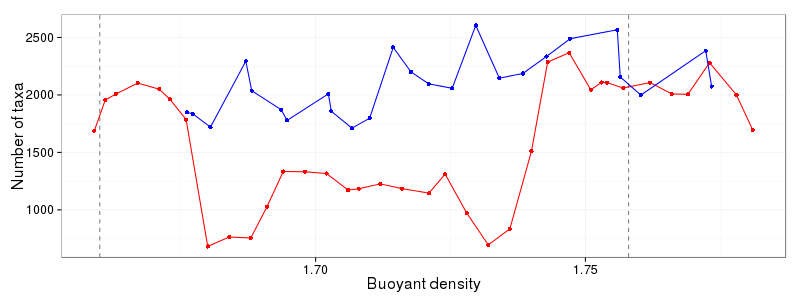

In [238]:
%%R -w 800 -h 300

# loading file
F = file.path(OTU.table.dir, OTU.table.file)
df.OTU = read.delim(F, sep='\t')

## edit table
df.OTU.nt = df.OTU %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

#### Notes

* blue = emperical data 
* red = simulated data

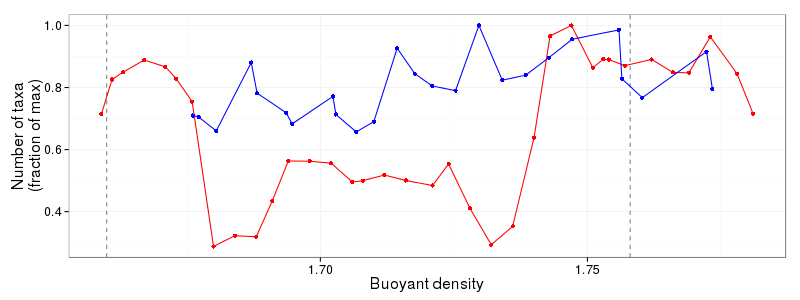

In [239]:
%%R -w 800 -h 300
# normalized by max number of taxa

## edit table
df.OTU.nt = df.OTU.nt %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))

df.OTU.real = df.OTU.real %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))


## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa_norm)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa\n(fraction of max)') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

## Plotting Shannon diversity for each

In [240]:
%%R
shannon_index_long = function(df, abundance_col, ...){
    # calculating shannon diversity index from a 'long' formated table
    ## community_col = name of column defining communities
    ## abundance_col = name of column defining taxon abundances
    cmd = paste0(abundance_col, '/sum(', abundance_col, ')')
    df.s = df %>%
        group_by_(...) %>%
        mutate_(REL_abundance = cmd) %>%
        mutate(pi__ln_pi = REL_abundance * log(REL_abundance),
               shannon = -sum(pi__ln_pi, na.rm=TRUE)) %>%
        ungroup() %>%
        select(-REL_abundance, -pi__ln_pi) %>%
        distinct_(...) 
    return(df.s)
}

In [241]:
%%R
# OTU table of real data
df.OTU = physeq.SIP.core %>% otu_table %>%
    as.matrix %>% as.data.frame
df.OTU$OTU = rownames(df.OTU)
df.OTU = df.OTU %>%    
    gather(sample, abundance, 1:(ncol(df.OTU)-1)) 

df.OTU.real = inner_join(df.OTU, physeq.SIP.core.m, c('sample' = 'X.Sample')) %>%
    select(-Sample_type, -Exp_type, -Sample_location, 
           -Sample_date, -Sample_treatment, -Sample_subtreatment)


df.OTU.real %>% head(n=3)

       OTU            sample abundance primer_number fwd_barcode rev_barcode
1 OTU.1101 12C-Con.D1.R2_F23         2           134    TCGACGAG    TGAGTACG
2 OTU.1130 12C-Con.D1.R2_F23         0           134    TCGACGAG    TGAGTACG
3 OTU.9833 12C-Con.D1.R2_F23         0           134    TCGACGAG    TGAGTACG
  Substrate Day Microcosm_replicate Fraction Buoyant_density        library
1   12C-Con   1                   2       23         1.69362 150721_V4_Lib4
2   12C-Con   1                   2       23         1.69362 150721_V4_Lib4
3   12C-Con   1                   2       23         1.69362 150721_V4_Lib4
  core_dataset
1         TRUE
2         TRUE
3         TRUE


In [242]:
%%R

# OTU table of simulated OTUs
F = file.path(OTU.table.dir, OTU.table.file)
df.OTU.nt = read.delim(F, sep='\t')

df.OTU.nt %>% head(n=3)

  library    fraction taxon BD_min BD_mid BD_max count    rel_abund
1       1  -inf-1.660 OTU.1   -Inf  1.659  1.659     1 7.742935e-05
2       1 1.660-1.662 OTU.1  1.660  1.661  1.662     4 2.636609e-04
3       1 1.662-1.665 OTU.1  1.662  1.663  1.665     5 4.111504e-04


In [243]:
%%R
# calculating shannon
df.OTU.nt.shan = shannon_index_long(df.OTU.nt, 'count', 'library', 'fraction')
df.OTU.real.shan = shannon_index_long(df.OTU.real, 'abundance', 'sample')

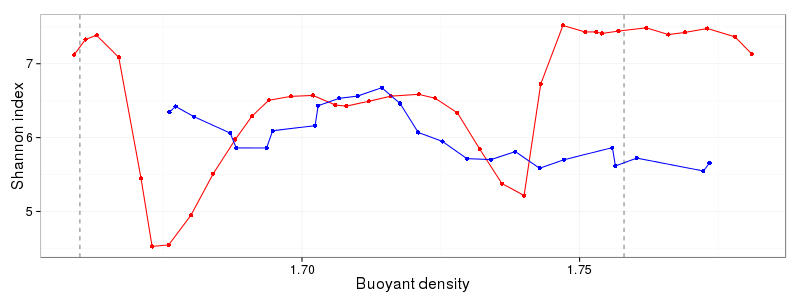

In [244]:
%%R -w 800 -h 300
# plotting
p = ggplot(df.OTU.nt.shan, aes(BD_mid, shannon)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real.shan, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real.shan, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Shannon index') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

# Plotting taxon abundance distribution for emperical data

In [178]:
%%R -i physeqDir -i physeq_SIP_core -i bulk_days

# bulk core samples
F = file.path(physeqDir, physeq_SIP_core)
physeq.SIP.core = readRDS(F) 
physeq.SIP.core.m = physeq.SIP.core %>% sample_data

physeq.SIP.core = prune_samples(physeq.SIP.core.m$Substrate == '12C-Con' & 
                                physeq.SIP.core.m$Day %in% bulk_days, 
                                physeq.SIP.core) %>%
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.SIP.core.m = physeq.SIP.core %>% sample_data        

physeq.SIP.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7025 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 7025 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7025 tips and 7024 internal nodes ]


In [179]:
%%R -w 800 -h 300 

## dataframe
df.OTU = physeq.SIP.core %>% otu_table %>%
    as.matrix %>% as.data.frame
df.OTU$OTU = rownames(df.OTU)
df.OTU = df.OTU %>%    
    gather(sample, abundance, 1:(ncol(df.OTU)-1)) #%>%
    #group_by(sample) %>%
    #summarize(n_taxa = sum(abundance > 0)) %>%
    #ungroup()

df.OTU.real = inner_join(df.OTU, physeq.SIP.core.m, c('sample' = 'X.Sample')) %>%
    group_by(sample) %>%
    mutate(rel_abund = abundance / sum(abundance))

df.OTU.real %>% head(n=3) %>% as.data.frame


       OTU            sample abundance primer_number fwd_barcode rev_barcode
1 OTU.1101 12C-Con.D1.R2_F23         2           134    TCGACGAG    TGAGTACG
2 OTU.1130 12C-Con.D1.R2_F23         0           134    TCGACGAG    TGAGTACG
3 OTU.9833 12C-Con.D1.R2_F23         0           134    TCGACGAG    TGAGTACG
  Substrate Day Microcosm_replicate Fraction Buoyant_density Sample_type
1   12C-Con   1                   2       23         1.69362     unknown
2   12C-Con   1                   2       23         1.69362     unknown
3   12C-Con   1                   2       23         1.69362     unknown
         library Exp_type Sample_location Sample_date Sample_treatment
1 150721_V4_Lib4      SIP              NA          NA               NA
2 150721_V4_Lib4      SIP              NA          NA               NA
3 150721_V4_Lib4      SIP              NA          NA               NA
  Sample_subtreatment core_dataset    rel_abund
1                  NA         TRUE 0.0001485001
2                  N

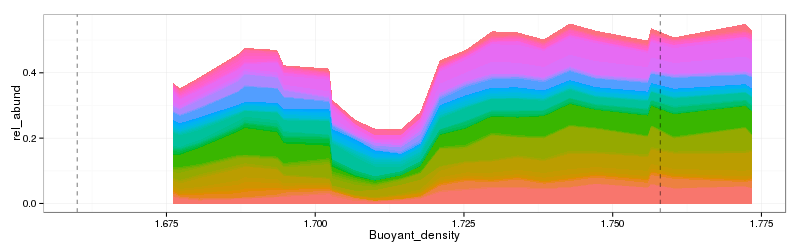

In [180]:
%%R -w 800 -h 250
## most abundant taxa 
df.OTU.real.s = df.OTU.real %>% 
    group_by(OTU) %>%
    summarize(mean_rel_abund = mean(rel_abund)) %>%
    ungroup() %>%
    mutate(rank_abund = row_number(-mean_rel_abund)) %>%
    filter(rank_abund <= 50)

df.OTU.real.j = inner_join(df.OTU.real.s, df.OTU.real, c('OTU' = 'OTU'))

p1 = ggplot(df.OTU.real.j, aes(Buoyant_density, rel_abund, fill=OTU)) +
    geom_area(stat='identity', position='stack') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        legend.position = 'none'
    )

p1

# Plotting simulated taxon abundance distributions

In [181]:
%%R
OTU.table.dir = '/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/DBL_xRich/4000/'

### OTU table (no PCR or neg-binom)

In [182]:
%%R

# simulated file info
OTU.table.file = 'OTU_abs5e9.txt'

# loading file
F = file.path(OTU.table.dir, OTU.table.file)
df.sim = read.delim(F, sep='\t')


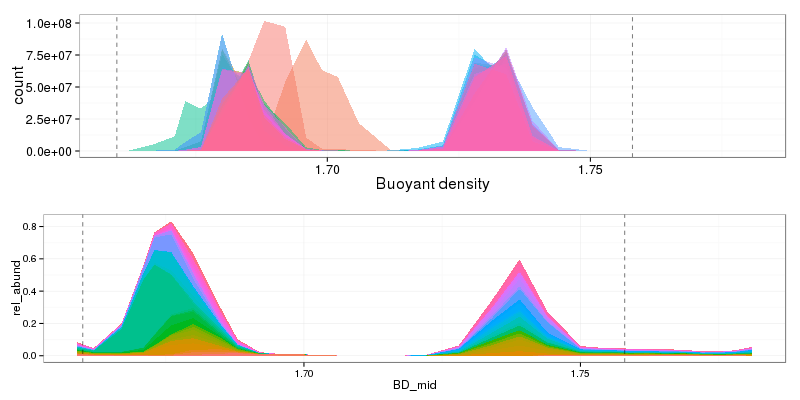

In [183]:
%%R -w 800 -h 400
## most abundant taxa 
df.sim.s = df.sim %>% 
    group_by(taxon) %>%
    summarize(mean_rel_abund = mean(rel_abund)) %>%
    ungroup() %>%
    mutate(rank_abund = row_number(-mean_rel_abund)) %>%
    filter(rank_abund <= 50)

df.sim.j = inner_join(df.sim.s, df.sim, c('taxon' = 'taxon'))


p1 = ggplot(df.sim.j, aes(BD_mid, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = ggplot(df.sim.j, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_area(stat='identity', position='stack') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        legend.position = 'none'
    )
grid.arrange(p1, p2, ncol=1)

### OTU table w/ subsampling

In [184]:
%%R

# simulated file info
OTU.table.file = 'OTU_abs5e9_sub.txt'

# loading file
F = file.path(OTU.table.dir, OTU.table.file)
df.sim = read.delim(F, sep='\t')

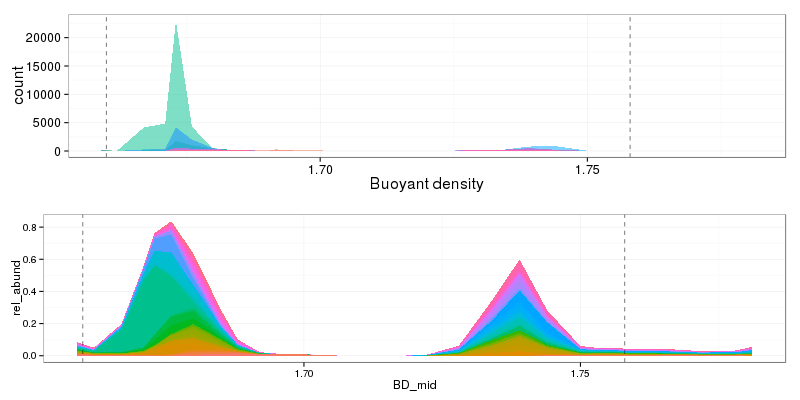

In [185]:
%%R -w 800 -h 400
## most abundant taxa 
df.sim.s = df.sim %>% 
    group_by(taxon) %>%
    summarize(mean_rel_abund = mean(rel_abund)) %>%
    ungroup() %>%
    mutate(rank_abund = row_number(-mean_rel_abund)) %>%
    filter(rank_abund <= 50)

df.sim.j = inner_join(df.sim.s, df.sim, c('taxon' = 'taxon'))


p1 = ggplot(df.sim.j, aes(BD_mid, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = ggplot(df.sim.j, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_area(stat='identity', position='stack') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        legend.position = 'none'
    )
grid.arrange(p1, p2, ncol=1)

### OTU table w/ subsampling & sampling error

In [186]:
%%R

# simulated file info
OTU.table.file = 'OTU_abs5e9_sub_negBin.txt'

# loading file
F = file.path(OTU.table.dir, OTU.table.file)
df.sim = read.delim(F, sep='\t')


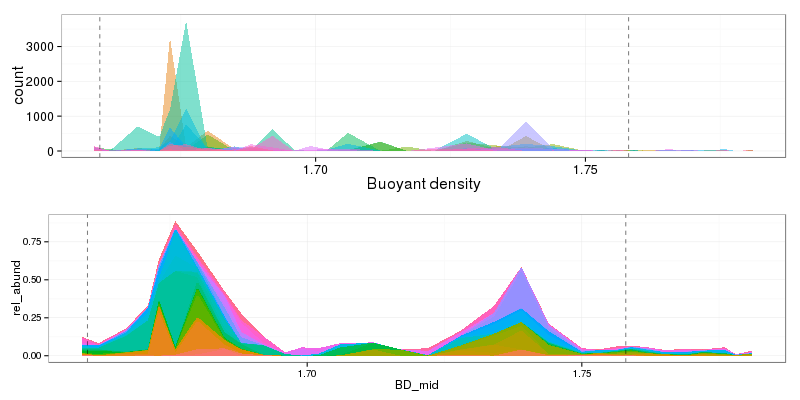

In [187]:
%%R -w 800 -h 400
## most abundant taxa 
df.sim.s = df.sim %>% 
    group_by(taxon) %>%
    summarize(mean_rel_abund = mean(rel_abund)) %>%
    ungroup() %>%
    mutate(rank_abund = row_number(-mean_rel_abund)) %>%
    filter(rank_abund <= 50)

df.sim.j = inner_join(df.sim.s, df.sim, c('taxon' = 'taxon'))


p1 = ggplot(df.sim.j, aes(BD_mid, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = ggplot(df.sim.j, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_area(stat='identity', position='stack') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        legend.position = 'none'
    )
grid.arrange(p1, p2, ncol=1)

### OTU table w/ PCR & subsampling

In [188]:
%%R

# simulated file info
OTU.table.file = 'OTU_abs5e9_PCR_sub.txt'

# loading file
F = file.path(OTU.table.dir, OTU.table.file)
df.sim = read.delim(F, sep='\t')


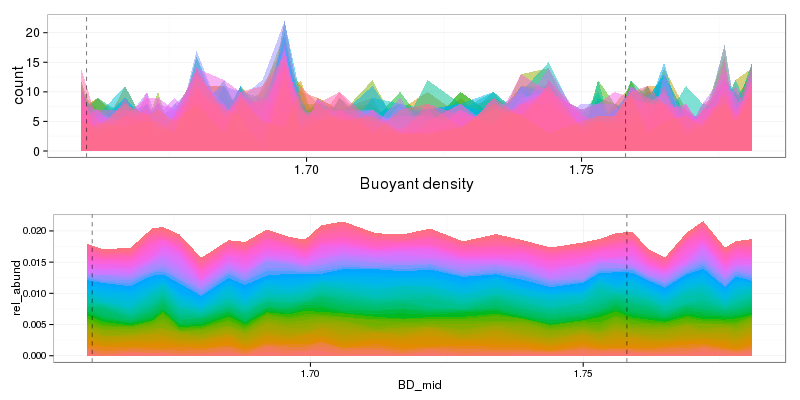

In [189]:
%%R -w 800 -h 400
## most abundant taxa 
df.sim.s = df.sim %>% 
    group_by(taxon) %>%
    summarize(mean_rel_abund = mean(rel_abund)) %>%
    ungroup() %>%
    mutate(rank_abund = row_number(-mean_rel_abund)) %>%
    filter(rank_abund <= 50)

df.sim.j = inner_join(df.sim.s, df.sim, c('taxon' = 'taxon'))


p1 = ggplot(df.sim.j, aes(BD_mid, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = ggplot(df.sim.j, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_area(stat='identity', position='stack') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        legend.position = 'none'
    )
grid.arrange(p1, p2, ncol=1)

### OTU table w/ PCR & sampling error

In [190]:
%%R
# simulated file info
OTU.table.file = 'OTU_abs5e9_PCR_sub_negBin.txt'

# loading file
F = file.path(OTU.table.dir, OTU.table.file)
df.sim = read.delim(F, sep='\t')


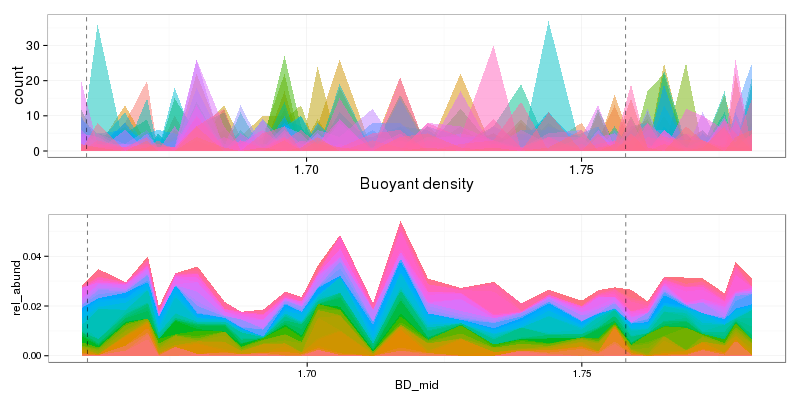

In [191]:
%%R -w 800 -h 400

## most abundant taxa 
df.sim.s = df.sim %>% 
    group_by(taxon) %>%
    summarize(mean_rel_abund = mean(rel_abund)) %>%
    ungroup() %>%
    mutate(rank_abund = row_number(-mean_rel_abund)) %>%
    filter(rank_abund <= 50)

df.sim.j = inner_join(df.sim.s, df.sim, c('taxon' = 'taxon'))


p1 = ggplot(df.sim.j, aes(BD_mid, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = ggplot(df.sim.j, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_area(stat='identity', position='stack') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        legend.position = 'none'
    )
grid.arrange(p1, p2, ncol=1)